In [1]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

d:\College\III_year_II_part\WDSS\jupyter_notebooks
d:\College\III_year_II_part\WDSS


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

import tqdm

from typing import List, Tuple, Dict

from config import device, Settings
from commons import initialize

In [3]:
settings = Settings("config/config.json", "WDSSV5")
initialize(settings=settings)

Job: myassnigga, Model: WDSSV5, Device: cuda
Model path: out\myassnigga-WDSSV5\model
Log path: out\myassnigga-WDSSV5\logs


In [4]:
from network.dataset import *

# Load the dataset
dataset = WDSSDatasetCompressed(settings.train_dir, 119)

# Load the raw frames
raw_frames = dataset._get_raw_frames(3, True)

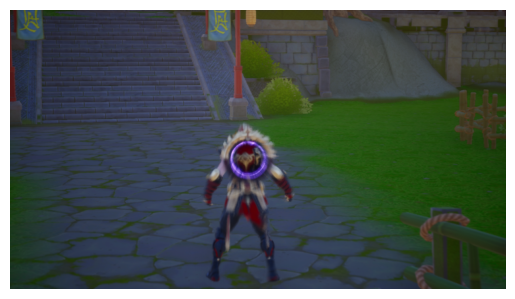

In [5]:
hr = raw_frames[RawFrameGroup.HR]
ImageUtils.display_image(hr)

In [6]:
def plot_histogram(image, title):
    plt.figure(figsize=(10, 4))
    plt.hist(image.ravel(), bins=256, color='orange')
    plt.hist(image[:, :, 0].ravel(), bins=256, color='red', alpha=0.5)
    plt.hist(image[:, :, 1].ravel(), bins=256, color='Green', alpha=0.5)
    plt.hist(image[:, :, 2].ravel(), bins=256, color='Blue', alpha=0.5)
    plt.xlabel('Intensity Value')
    plt.ylabel('Count')
    plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
    plt.title(title)
    plt.show()

def plot_fourier_transform(image, title):
    f_transform = np.fft.fft2(image)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = 20 * np.log(np.abs(f_shift))
    
    plt.figure(figsize=(10, 4))
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

# Create a single histogram for the HR frames only
hr_images = []
for i in tqdm.tqdm(range(len(dataset))):
    raw_frames = dataset._get_raw_frames(i, True)
    image = raw_frames[RawFrameGroup.HR].cpu().numpy().transpose(1, 2, 0)
    hr_images.append(image)
# for frame_group, frame_data in raw_frames.items():
#     if frame_group == RawFrameGroup.HR:
#         image = frame_data.cpu().numpy().transpose(1, 2, 0)
#         hr_images.append(image)

hr_images = np.concatenate(hr_images, axis=0)
plot_histogram(hr_images, 'Histogram for HR Frames')

# Visualize the frequency for HR frames only
hr_image = raw_frames[RawFrameGroup.HR].cpu().numpy().transpose(1, 2, 0)
plot_fourier_transform(hr_image, 'Fourier Transform of HR Frames')


  4%|▍         | 20/476 [00:08<03:20,  2.28it/s]


Error in _get_gbuffer: Attempt to use ZIP archive that was already closed, depth: 0
Error in _get_gbuffer: Attempt to use ZIP archive that was already closed, depth: 1
Error in _get_gbuffer: Attempt to use ZIP archive that was already closed, depth: 2
Error in _get_gbuffer: Attempt to use ZIP archive that was already closed, depth: 3
Error in _get_gbuffer: Attempt to use ZIP archive that was already closed, depth: 4
Error in _get_gbuffer: Attempt to use ZIP archive that was already closed, depth: 5
Error in _get_gbuffer: Attempt to use ZIP archive that was already closed, depth: 6


KeyboardInterrupt: 

GB_Type.BASE_COLOR - Min: 0.0, Max: 0.80859375, Mean: 0.07324233651161194, Std: 0.0476238988339901


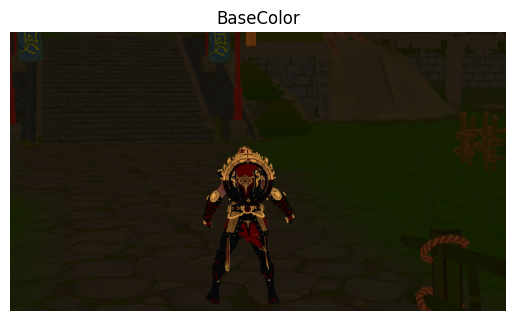

GB_Type.DIFFUSE_COLOR - Min: 0.0, Max: 1.0, Mean: 0.07020200043916702, Std: 0.04505189508199692


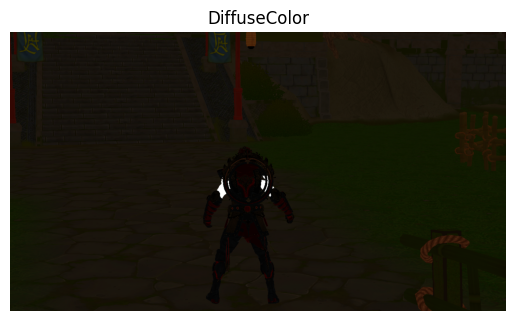

GB_Type.MOTION_VECTOR - Min: -22.15625, Max: 23.421875, Mean: -0.3163853585720062, Std: 2.1702141761779785


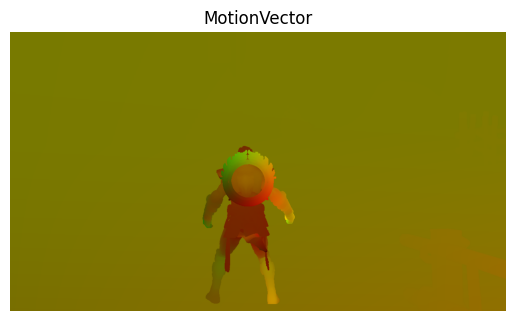

GB_Type.NoV - Min: 0.0, Max: 1.0, Mean: 0.41859179735183716, Std: 0.3088305592536926


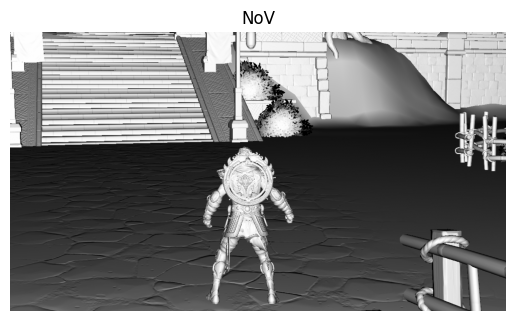

GB_Type.DEPTH - Min: 0.057891845703125, Max: 0.65966796875, Mean: 0.22332853078842163, Std: 0.12433334439992905


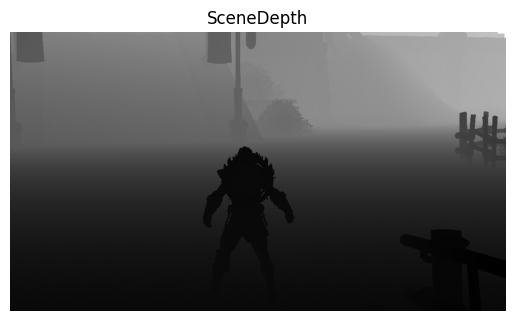

GB_Type.NORMAL - Min: -1.0, Max: 1.0, Mean: 0.12193705141544342, Std: 0.5642454624176025


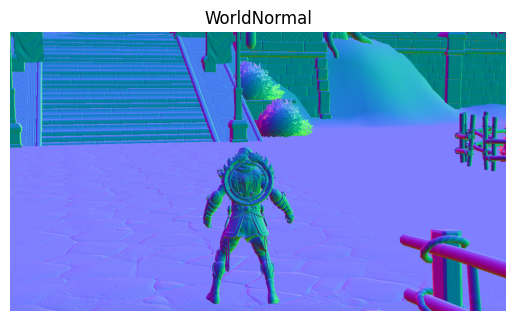

GB_Type.METALLIC - Min: 0.0, Max: 1.0, Mean: 0.015921451151371002, Std: 0.1134447231888771


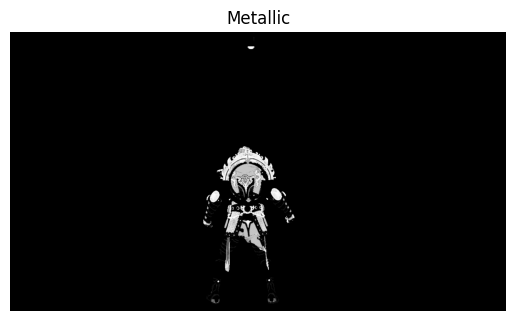

GB_Type.ROUGHNESS - Min: 0.0, Max: 1.0, Mean: 0.9769052863121033, Std: 0.10579824447631836


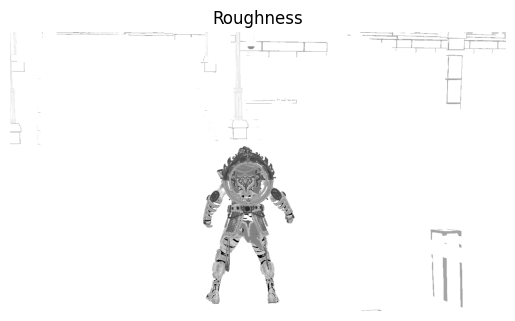

GB_Type.SPECULAR - Min: 0.0, Max: 0.8115234375, Mean: 0.18692892789840698, Std: 0.22040985524654388


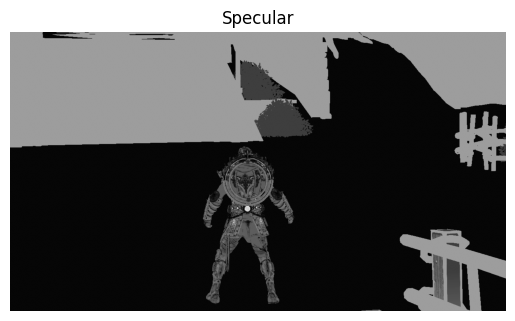

In [32]:

# Assuming gbuffers is a variable containing the image data
raw_frames = dataset._get_raw_frames(3, True)
gbuffers = raw_frames[RawFrameGroup.HR_GB]
for item, image in gbuffers.items():
    display_value_range(image, item)

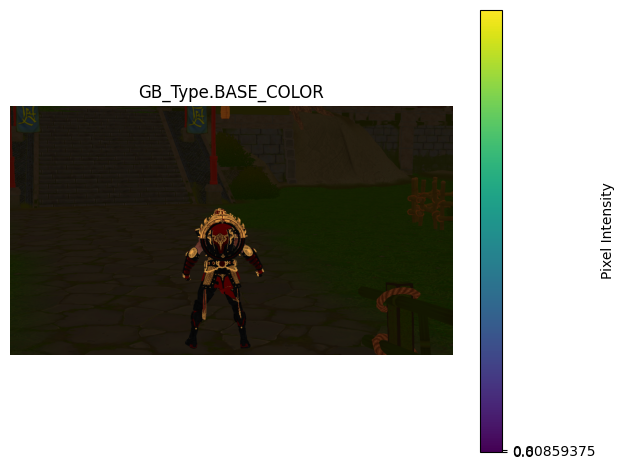

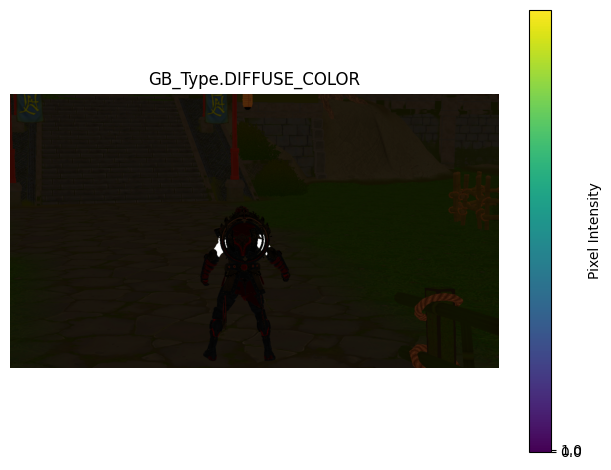

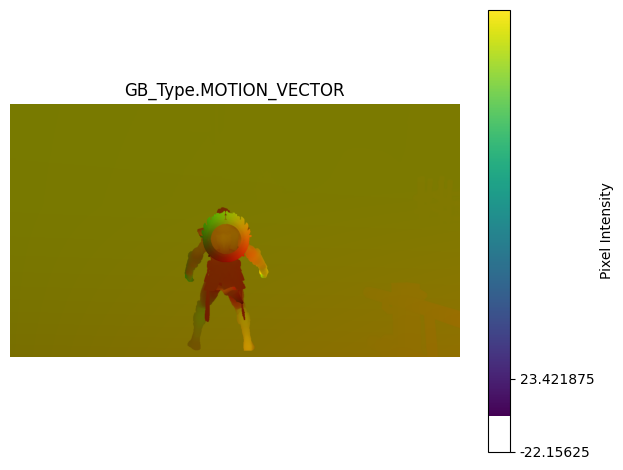

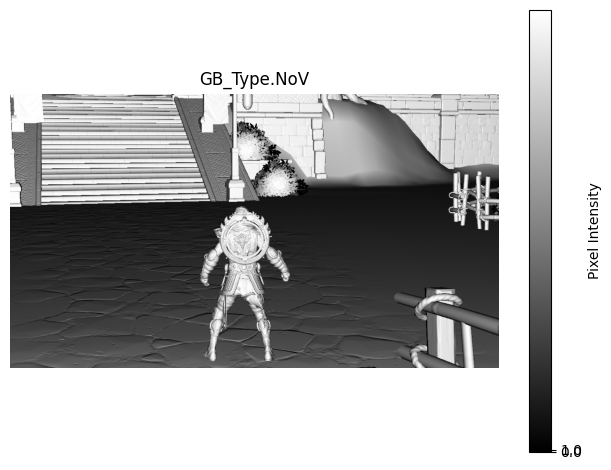

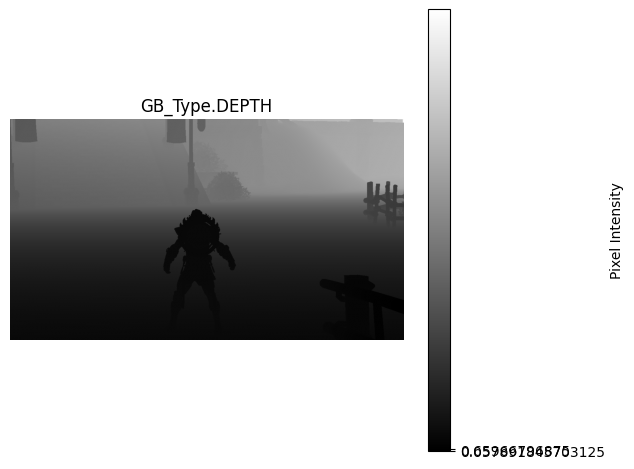

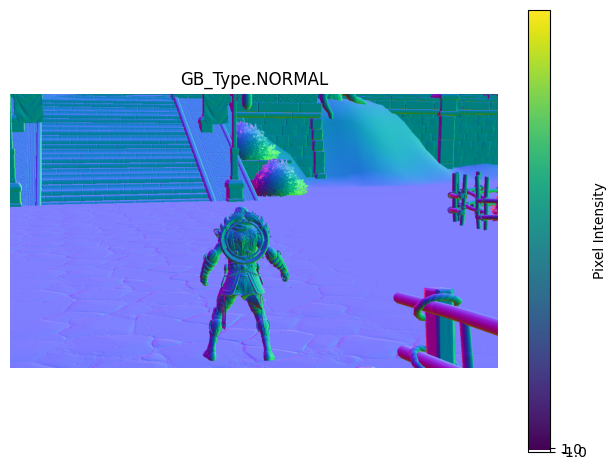

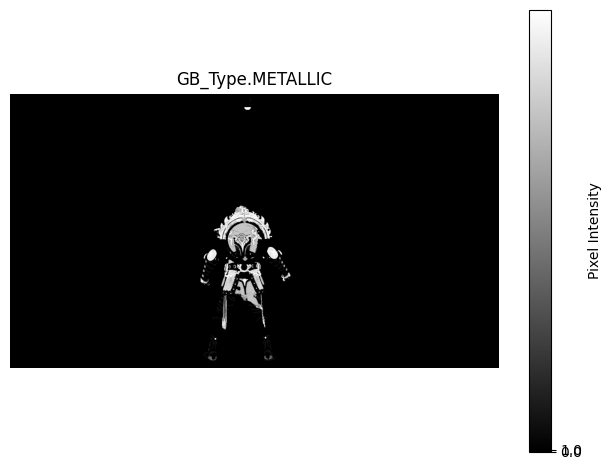

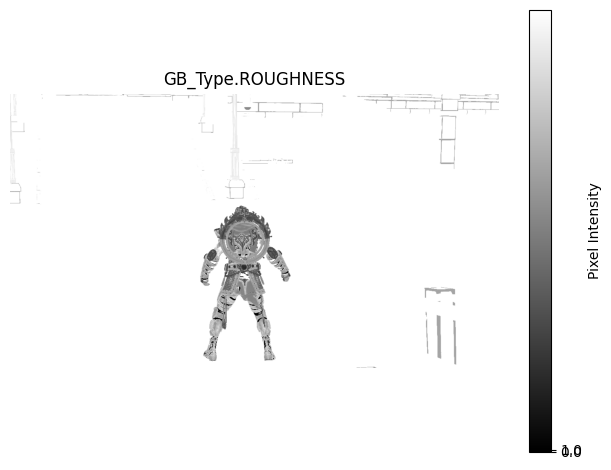

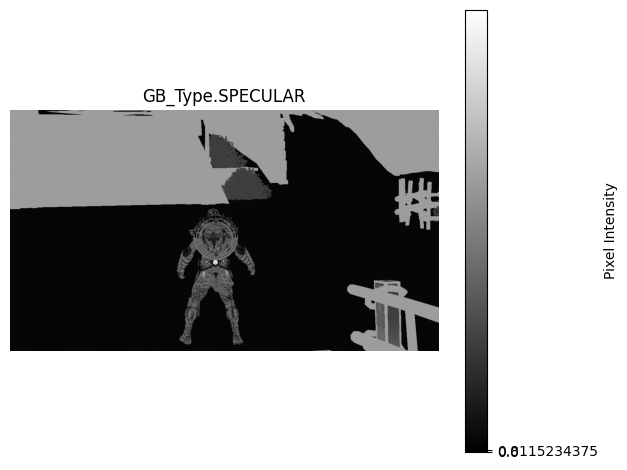

In [6]:
raw_frames = dataset._get_raw_frames(3, True)
gbuffers = raw_frames[RawFrameGroup.HR_GB]
for item, image in gbuffers.items():
    ImageUtils.display_image_scale(image, item)